# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import keras

# Load the Dataset using tf batch processing

In [2]:
img_height = 256
img_width = 256
batch_size = 32
channels = 3
epoch = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('Bell pepper dataset', 
                                                    shuffle = True,
                                                    image_size = (img_height, img_width),
                                                    batch_size = batch_size
                                                   )

Found 2475 files belonging to 2 classes.


# Explore the Dataset

In [4]:
class_name = dataset.class_names
class_name

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
len(dataset)

78

In [6]:
for image_batch, label_batch in dataset.take(1): # takes one batch
    print(image_batch.shape)
    print(label_batch.numpy()) # convert the elements from tensors to numpy

(32, 256, 256, 3)
[0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0]


In [7]:
print(image_batch[0].shape)
# print(image_batch[0]) # first image in tensor
# print(image_batch[0].numpy()) # convert first image from tensor to numpy

(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

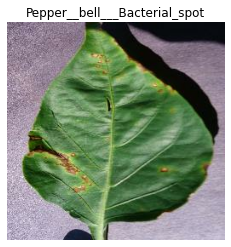

In [8]:
plt.imshow(image_batch[0].numpy().astype('uint8')) # using numpy astype lets the image visualize properly
plt.title(class_name[label_batch[0]]) # use indexing to get the class name of image displayed
plt.axis('off') # removes the x and y axis labels

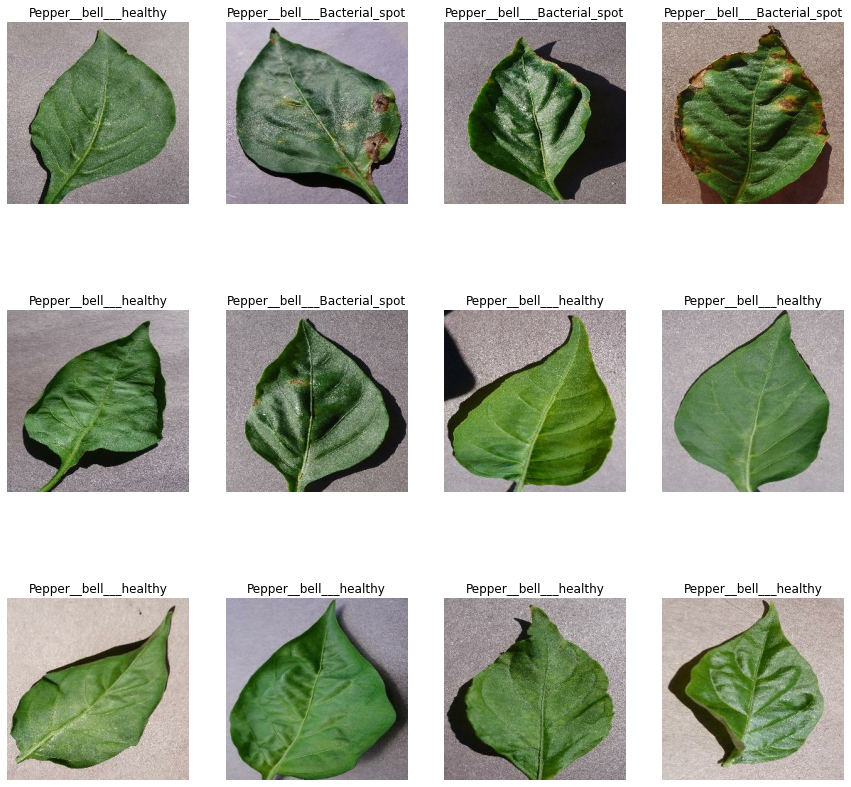

In [9]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for img in range(12):
        ax = plt.subplot(3,4, img+1)
        plt.imshow(image_batch[img].numpy().astype('uint8'))
        plt.title(class_name[label_batch[img]]) 
        plt.axis('off')

# Split Dataset into Train and Test

## 80% ==> training
## 20% ==> 10% validation, 10% testing

In [10]:
training_size = 0.8  # 80%
len(dataset) * training_size

62.400000000000006

In [11]:
train_ds = dataset.take(54) # takes the first 54 set
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54) # would skip the first 54 set and go on to the next 54 set
len(test_ds)

24

In [13]:
val_size = 0.1 #10%
len(dataset) * val_size

7.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

18

## Using function to perform train, val, test split

In [16]:
def get_dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1,
                          shuffle= True, shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
#     test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds =  ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)
train_ds, val_ds, test_ds

(<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>,
 <TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>,
 <SkipDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>)

In [18]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

62
7
9


In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Preprocessing
## Normalize the images

In [20]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_height, img_width),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Augment the image to help the model predict better

In [21]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
# class myCallback(tf.keras.callbacks.Callback):

#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('accuracy')>0.98):
#       print("\nReached 98% accuracy so cancelling training!")
#       self.model.stop_training = True

# callbacks = myCallback()

# Model Building

In [23]:
input_shape = (batch_size, img_height, img_width, channels)
num_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),   
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs=epoch,
#     callbacks=[callbacks],
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
62/62 [==============================] - 148s 2s/step - loss: 0.5623 - accuracy: 0.7652 - val_loss: 0.2977 - val_accuracy: 0.9062
Epoch 2/50
62/62 [==============================] - 134s 2s/step - loss: 0.2785 - accuracy: 0.9129 - val_loss: 0.7646 - val_accuracy: 0.7723
Epoch 3/50
62/62 [==============================] - 133s 2s/step - loss: 0.2232 - accuracy: 0.9215 - val_loss: 0.2884 - val_accuracy: 0.8705
Epoch 4/50
62/62 [==============================] - 133s 2s/step - loss: 0.1083 - accuracy: 0.9715 - val_loss: 0.0445 - val_accuracy: 0.9821
Epoch 5/50
62/62 [==============================] - 134s 2s/step - loss: 0.0580 - accuracy: 0.9878 - val_loss: 0.0353 - val_accuracy: 0.9911
Epoch 6/50
62/62 [==============================] - 131s 2s/step - loss: 0.0517 - accuracy: 0.9873 - val_loss: 0.1761 - val_accuracy: 0.9152
Epoch 7/50
62/62 [==============================] - 131s 2s/step - loss: 0.0823 - accuracy: 0.9755 - val_loss: 0.0956 - val_accuracy: 0.9643
Epoch 8/50
62

In [27]:
score = model.evaluate(test_ds)

9/9 [==============================] - 12s 702ms/step - loss: 0.0083 - accuracy: 0.9965


In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

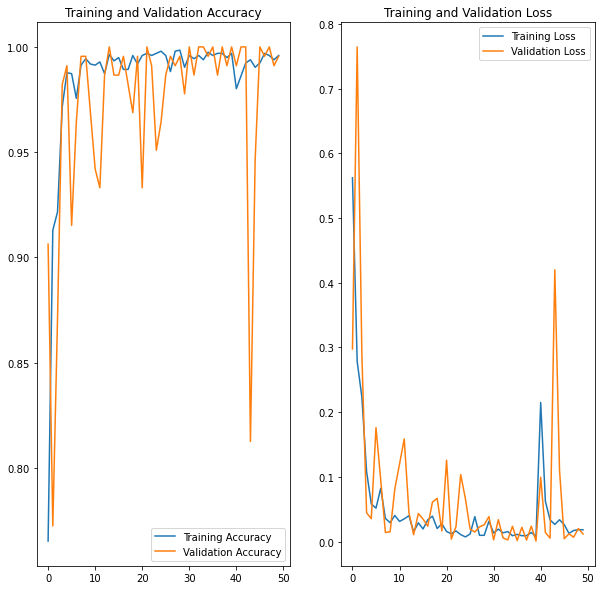

In [31]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(epoch), acc, label = 'Training Accuracy')
plt.plot(range(epoch), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epoch), loss, label = 'Training Loss')
plt.plot(range(epoch), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Make Prediction

First image to predict
Actual label:  Pepper__bell___healthy
Predicted label:  Pepper__bell___healthy


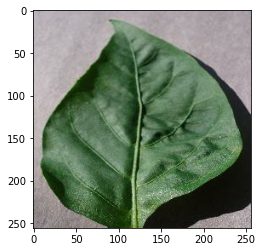

In [38]:
for image_batch, label_batch in test_ds.take(1):
    
#     print(image_batch[0].numpy().astype('uint8'))
#     plt.imshow(image_batch[0].numpy().astype('uint8'))
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual label: ', class_name[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('Predicted label: ', class_name[np.argmax(batch_prediction[0])])

First image to predict
Actual label:  Pepper__bell___healthy
Predicted label:  Pepper__bell___healthy


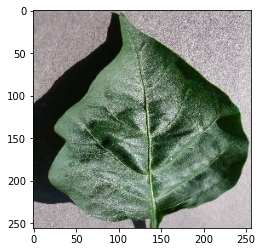

In [44]:
first_image = image_batch[2].numpy().astype('uint8')
first_label = label_batch[2]
print('First image to predict')
plt.imshow(first_image)
print('Actual label: ', class_name[first_label])
    
batch_prediction = model.predict(image_batch)
print('Predicted label: ', class_name[np.argmax(batch_prediction[2])])

### Save model for later

In [45]:
# use this to manually save your models, dont forget to rename the model version when you tune hyperparameters
model.save("../models/version_1", save_format='h5')